,mass,deformity,length,thickness
count,40.00000,40.000000,40.000000,40.000000
mean,36.95000,0.192500,30.173750,0.651250
std,4.36742,0.599204,0.295259,0.129222
min,26.00000,0.000000,29.800000,0.500000
25%,35.75000,0.000000,30.000000,0.545000
50%,37.00000,0.000000,30.000000,0.600000
75%,39.00000,0.062500,30.400000,0.800000
max,49.00000,3.000000,31.100000,0.800000


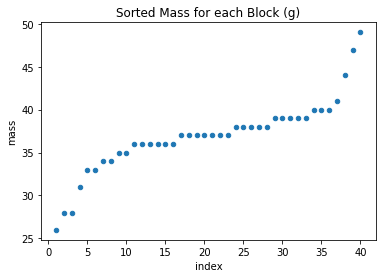

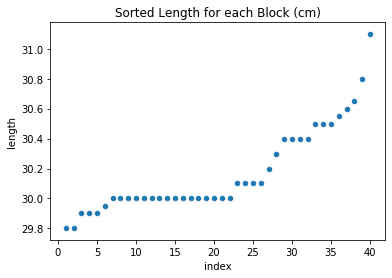

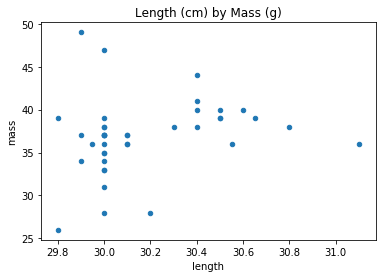

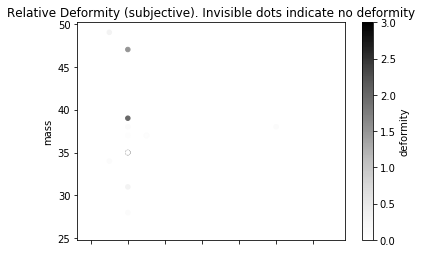

In [40]:
"""
Data Collection
The math will be incorrect under the assumption that all 
blocks are identical in length and mass. Each block is different,
and considering the differences in each block can help yield the 
best performance. 

Deformity is the qualitative measure of the level of curvature along 
the length of each block. The higher the number, the more warped the 
block.
"""

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("brick_params.csv").sort_values(by=['mass', 'length']).reset_index(drop=True)
df['index'] = range(1, len(df) + 1)

df.plot.scatter(x='index',y='mass',title='Sorted Mass for each Block (g)')

df2 = df.sort_values(by=['length', 'mass']).reset_index(drop=True)
df2['index'] = range(1, len(df) + 1)

df2.plot.scatter(x='index',y='length',title='Sorted Length for each Block (cm)')
weight = pd.DataFrame({"mass":[10.0],"deformity":[0.0],"length":[0.6],"thickness":[0.6]})

df2.plot.scatter(x='length', y='mass', title='Length (cm) by Mass (g)')
df2.plot.scatter(x='length', y='mass', c='deformity', title='Relative Deformity (subjective). Invisible dots indicate no deformity')

df = df.drop("index", axis=1)
df.describe()

In [41]:
"""
This method, which I will call the linear method repeats these steps:

 1. If there are existing blocks, shift every block up. (Actually not in the code. 
 Intuitively, this happens. Mathematically, this is not necessary.)
 2. Place a new block on the table (underneath existing blocks if applicable)
 3. Shift the entire system's center of mass to the edge of the table.  

The edge of the table is defined at x=0, before the edge is x<0.
"""

def get_shift(df):
    # make center of mass for the block the difference between the right position and the x component of the center
    # of mass considering the block and the point mass at the very left of the block. 
    df["center_x"] = df.right_x - ((df.length*0.5*df.mass)-(df.length*df.mass_placed_on_leftmost_point))/(df.mass+df.mass_placed_on_leftmost_point)
    df["x_times_m"] = df.center_x * df.mass
    com = df.x_times_m.sum() / df.mass.sum()
    shift = -1 * com
    if shift < 0:
        print(df, com, shift)
        raise Exception('Unexpected Shift')
    return shift

# linear method places the last block first, first block last. The first block gets the point mass
def linear_method(df, point_mass=10):
    
    df["mass_placed_on_leftmost_point"] = 0 # Place a mass of 0g as far to the left as possible for each block
    df["right_x"] = 0

    first = df.iloc[[-20]]
    first.mass_placed_on_leftmost_point
    
    # Place the first block on the table
    build_df = pd.DataFrame(first)
    # Shift the system
    build_df.right_x += get_shift(build_df)

    # Iterate through the rest of the blocks in reverse order (to get the next 19)
    for i in range(1,20):
        block = pd.DataFrame(df.iloc[[-1*(20-i)]])
        
        # Place new block on the table
        build_df = build_df.append(block)
        
        # Shift the system 
        build_df.right_x += get_shift(build_df)
        
    
    build_df["x_times_m"] = build_df.center_x * build_df.mass
    build_df["upper_y"] = build_df.loc[::-1, "thickness"].cumsum()[::-1]
    build_df["cumulative_com"] = build_df.loc[::-1, "x_times_m"].cumsum()[::-1] / build_df.loc[::-1, "mass"].cumsum()[::-1]
    build_df["left_x"] = build_df.length - build_df.right_x
    build_df['shift'] = build_df['left_x'].sub(build_df['left_x'].shift())
    build_df['shift'].iloc[0] = build_df['left_x'].iloc[0]
    return build_df.copy(deep=True), build_df.right_x.max()
    

def score(data):
    build_df, score = linear_method(data.copy(deep=True).drop(data.tail(len(data)-20).index))
    return score

def get_instructions(data):
    build_df, score = linear_method(data.copy(deep=True).drop(data.tail(len(data)-20).index))
    return build_df[['label','right_x','left_x','shift']]

print(score(df))
get_instructions(df)


57.157445133484124


,label,right_x,left_x,shift
0,O,57.157445,-27.357445,-27.357445
1,AN,42.257445,-12.257445,15.100000
2,D,34.479667,-4.279667,7.977778
3,AG,29.323570,0.676430,4.956098
4,L,25.208526,4.791474,4.115044
5,AK,21.818115,8.181885,3.390411
6,AJ,19.052751,10.847249,2.665363
7,AI,16.666366,13.333634,2.486385
8,A,14.601589,15.398411,2.064777
9,N,12.739887,17.260113,1.861702


In [42]:
# # Uncomment and run this cell to find how long it takes to compute one iteration.
# import time
# initial = time.time()
# for i in range(0,100):
#     score(df)
# final = time.time()
# print((final - initial) / 100.0)

In [43]:
# The next issue is sorting them in the order that will optimize the length at the end. 
# Iterating through everything is 40 choose 20, or 137,846,528,820. I don't have that kind of power.
# Throwing out the most deformed block, A, yields only 68,923,264,410 combinations. Through
# making some strategic decisions, we can reduce these combinations to something we can reasonably loop through.
# we can iterate through.
by_length =  df.sort_values(by=['length', 'mass'], ascending=True).reset_index(drop=True)
score(by_length)

56.19355978107119

In [44]:
by_mass_ascending =  df.sort_values(by=['mass', 'length'], ascending=True).reset_index(drop=True)
score(by_mass_ascending)

57.157445133484124

In [45]:
#If sorted by mass improperly, this is the cost (all measurements in centimeters)
by_mass_descending =  df.sort_values(by=['mass', 'length'], ascending=False).reset_index(drop=True)
score(by_mass_ascending) - score(by_mass_descending)

5.356266787707732

In [46]:
# Strategic method 1: Throw out the most deformed block, 
# use the 10 longest blocks at the top and the 10 heaviest blocks at the bottom. 
# In the possibility of duplicates, give priority to mass. 
bank = df.copy(deep=True)
bank = bank[bank.deformity < bank.deformity.max()]
bank = bank.sort_values(by=['mass'], ascending=True)
method_1 = bank[-10:]
bank.drop(bank.tail(10).index,inplace=True)
bank = bank.sort_values(by=['length'], ascending=True)
method_1 = bank[-10:].append(method_1).reset_index(drop=True)

score(method_1)

55.33188141796793

In [47]:
# Strategic method 2: copy method 1 but prioritize length
bank = df.copy(deep=True)
bank = bank[bank.deformity < bank.deformity.max()]
bank = bank.sort_values(by=['length'], ascending=True)
method_2 = bank[-10:]
bank.drop(bank.tail(10).index,inplace=True)
bank = bank.sort_values(by=['mass'], ascending=True)
method_2 = bank[-10:].append(method_2).reset_index(drop=True)

score(method_2)

55.1089490601695

In [48]:
# Strategic method 3: Prioritize mass, but adjust the cutoff of 10 through numbers 0-19
def method_3(cutoff, prints=True):
    bank = df.copy(deep=True)
    bank = bank[bank.deformity < bank.deformity.max()]
    bank = bank.sort_values(by=['mass'], ascending=True)
    method_3 = bank[-cutoff:]
    bank.drop(bank.tail(10).index,inplace=True)
    bank = bank.sort_values(by=['length'], ascending=True)
    method_3 = bank[-(20-cutoff):].append(method_3).reset_index(drop=True)
    
    sc = score(method_3)
    if prints:
        print("Score using the top {} highest masses and using the top {} highest lengths: {}".format(cutoff, 20-cutoff, sc))
    return sc, method_3

def method_3_score(cutoff):
    sc, a = method_3(cutoff)
    return sc

tests = {}

for cutoff in range(0,20):
    tests[cutoff] = method_3_score(cutoff)
    
    

best_cutoff = max(tests, key=tests.get)
sc, method_3_df = method_3(best_cutoff, prints=False)
print("\nBest uses {} highest masses and top {} highest lengths, score: {}".format(best_cutoff, 20-best_cutoff, sc))
method_3_df

Score using the top 0 highest masses and using the top 20 highest lengths: 54.36041026057652
Score using the top 1 highest masses and using the top 19 highest lengths: 54.975071161482134
Score using the top 2 highest masses and using the top 18 highest lengths: 55.5105409804055
Score using the top 3 highest masses and using the top 17 highest lengths: 55.741011524452944
Score using the top 4 highest masses and using the top 16 highest lengths: 56.17697133325501
Score using the top 5 highest masses and using the top 15 highest lengths: 54.79797023929127
Score using the top 6 highest masses and using the top 14 highest lengths: 57.23709106053732
Score using the top 7 highest masses and using the top 13 highest lengths: 54.96246258432724
Score using the top 8 highest masses and using the top 12 highest lengths: 55.104394801008375
Score using the top 9 highest masses and using the top 11 highest lengths: 55.43144080358935
Score using the top 10 highest masses and using the top 10 highest l

,label,mass,deformity,length,thickness
0,D,28,0.0,30.20,0.8
1,AD,38,0.0,30.30,0.8
2,AL,38,0.0,30.40,0.8
3,AA,36,0.0,30.55,0.8
4,X,39,0.0,30.65,0.8
5,C,38,0.1,30.80,0.8
6,R,36,0.0,31.10,0.6
7,C,38,0.1,30.80,0.8
8,U,39,2.0,30.00,0.5
9,X,39,0.0,30.65,0.8


In [49]:
# Strategic method 4: Prioritize length, but adjust the cutoff of 10 through numbers 0-19
def method_4(cutoff, prints=True):
    bank = df.copy(deep=True)
    bank = bank[bank.deformity < bank.deformity.max()]
    bank = bank.sort_values(by=['length'], ascending=True)
    method_4 = bank[-cutoff:]
    bank.drop(bank.tail(10).index,inplace=True)
    bank = bank.sort_values(by=['mass'], ascending=True)
    method_4 = bank[-(20-cutoff):].append(method_4).reset_index(drop=True)
    
    sc = score(method_4)
    if prints:
        print("Score using the top {} highest lengths and using the top {} highest masses: {}".format(cutoff, 20-cutoff, sc))
    return sc, method_4

def method_4_score(cutoff):
    sc, a = method_4(cutoff)
    return sc

tests = {}

for cutoff in range(0,20):
    tests[cutoff] = method_4_score(cutoff)
    
    

best_cutoff = max(tests, key=tests.get)
sc, method_4_df = method_4(best_cutoff, prints=False)
print("\nBest uses {} highest lengths and top {} highest masses, score: {}".format(best_cutoff, 20-best_cutoff, sc))
method_4_df

Score using the top 0 highest lengths and using the top 20 highest masses: 55.051854940323786
Score using the top 1 highest lengths and using the top 19 highest masses: 55.03746792442048
Score using the top 2 highest lengths and using the top 18 highest masses: 55.01210311979538
Score using the top 3 highest lengths and using the top 17 highest masses: 55.06051747278118
Score using the top 4 highest lengths and using the top 16 highest masses: 54.9172280983125
Score using the top 5 highest lengths and using the top 15 highest masses: 54.88570214406143
Score using the top 6 highest lengths and using the top 14 highest masses: 54.88144735171146
Score using the top 7 highest lengths and using the top 13 highest masses: 54.92463890422387
Score using the top 8 highest lengths and using the top 12 highest masses: 54.97930914587048
Score using the top 9 highest lengths and using the top 11 highest masses: 55.00762701078273
Score using the top 10 highest lengths and using the top 10 highest ma

,label,mass,deformity,length,thickness
0,E,37,0.0,30.00,0.60
1,AL,38,0.0,30.40,0.80
2,G,38,0.0,30.00,0.60
3,AB,38,0.1,30.00,0.55
4,AD,38,0.0,30.30,0.80
5,U,39,2.0,30.00,0.50
6,Z,39,0.0,29.80,0.80
7,AM,44,0.0,30.40,0.80
8,H,47,1.5,30.00,0.80
9,V,49,0.3,29.90,0.80


Conclusion: Strategic method number 3 is the most optimal method tested. There is a possibility for other sorting methods to perform better, yet one could reasonably assume that a different sorting method would not increase the total difference by a great amount. 

In [50]:
print(score(method_3_df))
get_instructions(method_3_df)

57.99846306431449


,label,right_x,left_x,shift
0,D,57.998463,-27.798463,-27.798463
1,AD,42.898463,-12.598463,15.200000
2,AL,34.175736,-3.775736,8.822727
3,AA,28.621890,1.928110,5.703846
4,X,24.694032,5.955968,4.027857
5,C,21.355066,9.444934,3.488966
6,R,18.658292,12.441708,2.996774
7,C,16.445644,14.354356,1.912648
8,U,14.434647,15.565353,1.210997
9,X,12.661920,17.988080,2.422727


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a7e3ed0>,
      dtype=object)

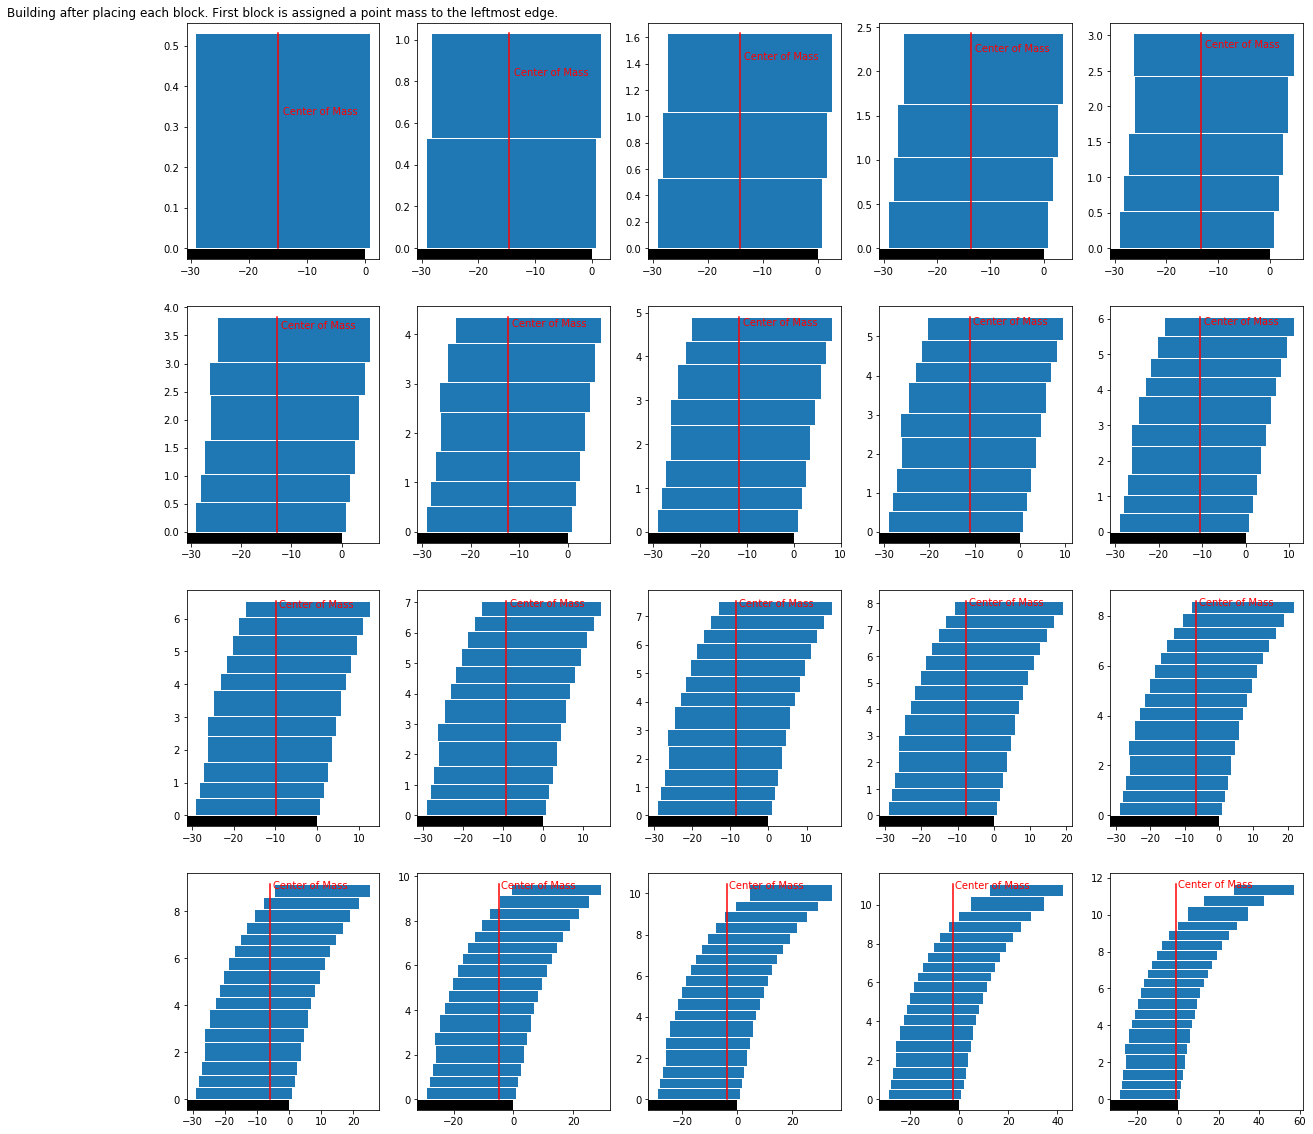

In [51]:
# Visualize the build_df

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize(fig, ax, df, saves=False, filename="linear.png", size=10, shows_table=True, i=1, n=1, plot_dim=[1,1]):
    
    max_height = df.upper_y.max()
    com = df.loc[0]["cumulative_com"]
    ax[int((i-1)/(plot_dim[0]+1)), (i-1)%plot_dim[1]].plot([com,com],[0,max_height], color='r')
    ax[int((i-1)/(plot_dim[0]+1)), (i-1)%plot_dim[1]].text(com + .8,max_height - 0.2,"Center of Mass",color='r')

    for index, block in df.iterrows():
        leftmost = block.right_x - block.length
        height = block.thickness
        length = block.length
        bottommost = block.upper_y - block.thickness
        rect = patches.Rectangle(
                (leftmost, bottommost),
                length,
                height,
                fill=True
             )
        rect.set_edgecolor('w')
        ax[int((i-1)/(plot_dim[0]+1)), (i-1)%plot_dim[1]].add_patch(rect)


    rect = patches.Rectangle(
            (leftmost, bottommost),
            length,
            height,
            fill=True
         )
    rect.set_edgecolor('w')
    ax[int((i-1)/(plot_dim[0]+1)), (i-1)%plot_dim[1]].add_patch(rect) 

    ax[int((i-1)/(plot_dim[0]+1)), (i-1)%plot_dim[1]].autoscale_view()

    min_right_row = df["right_x"].idxmin()
    min_left = df["right_x"][min_right_row] - df["length"][min_right_row]
    rect = patches.Rectangle(
            (min_left - 10, -10),
            -1 * (min_left - 10),
            10,
            fill=True
         )
    rect.set_color('k')
    rect.set_edgecolor('w')
    ax[int((i-1)/(plot_dim[0]+1)), (i-1)%plot_dim[1]].add_patch(rect) 
        
    if shows_table:
        ax[int((i-1)/(plot_dim[0]+1)), (i-1)%plot_dim[1]].text(-8,-.35,"Table",color='w')
    if saves:
        fig.savefig(filename, dpi=90, bbox_inches='tight')
        
size=20
plot_dim = [4,5]
fig, ax = plt.subplots(plot_dim[0],plot_dim[1],figsize=(size,size))

n=20
for i in range(1,n+1):
    visualize(fig, ax, build_df[-i:].reset_index(drop=True), size=size, shows_table=False, i=i, n=20, plot_dim = plot_dim, saves=True)

ax[0][0].set_title("Building after placing each block. First block is assigned a point mass to the leftmost edge.")
ax